Тема курсовой работы: Оптимизация ансамблевых методов в машинном обучении для задачи прогнозирования оттока клиентов»

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
# Предобработка данных
def preprocess_data(df):
    # Удаляем ненужный столбец
    df = df.drop('customerID', axis=1)
    
    # Разделяем на признаки и целевую переменную
    X = df.drop('Churn', axis=1)
    y = df['Churn']
    
    # Разделяем данные на тренировочный и тестовый наборы
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Определяем числовые и категориальные признаки
    numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    categorical_features = [col for col in X.columns if col not in numeric_features]
    
    # Создаем преобразователи для числовых и категориальных признаков
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Объединяем преобразователи в ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return X_train, X_test, y_train, y_test, preprocessor

In [5]:
# Оценка модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print(f"\nРезультаты для модели {model_name}:")
    print(classification_report(y_test, y_pred))
    print("Матрица ошибок:")
    print(confusion_matrix(y_test, y_pred))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc
    }

In [6]:
# Визуализация важности признаков
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(20)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title(f'Важность признаков для модели {model_name}')
        plt.show()

In [7]:
# Оптимизация LightGBM
def optimize_lightgbm(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }
    
    lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = RandomizedSearchCV(
        lgbm, param_dist, n_iter=20, scoring='f1', 
        cv=cv, verbose=1, random_state=42, n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Лучший F1-score: {search.best_score_}")
    
    return search.best_params_

In [8]:
# Оптимизация XGBoost
def optimize_xgb(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }
    
    xgb = XGBClassifier(random_state=42, scale_pos_weight=sum(y_train==0)/sum(y_train==1))
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = RandomizedSearchCV(
        xgb, param_dist, n_iter=20, scoring='f1', 
        cv=cv, verbose=1, random_state=42, n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Лучший F1-score: {search.best_score_}")
    
    return search.best_params_

In [52]:
data = pd.read_csv('churn.csv')
#Преобразуем TotalCharges в числовой тип и обработаем пропуски
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
        
#Избегаем chained assignment, присваивая результат обратно
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=False)
        
#Преобразуем целевую переменную
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

In [53]:
# Предобработка данных
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df)

In [54]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


In [55]:
print("Первые 5 строк данных:")
print(df.head())

Первые 5 строк данных:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovi

In [56]:
print("\nОписательная статистика:")
print(df.describe(include='all'))


Описательная статистика:
        customerID gender  SeniorCitizen Partner Dependents       tenure  \
count         7043   7043    7043.000000    7043       7043  7043.000000   
unique        7043      2            NaN       2          2          NaN   
top     7590-VHVEG   Male            NaN      No         No          NaN   
freq             1   3555            NaN    3641       4933          NaN   
mean           NaN    NaN       0.162147     NaN        NaN    32.371149   
std            NaN    NaN       0.368612     NaN        NaN    24.559481   
min            NaN    NaN       0.000000     NaN        NaN     0.000000   
25%            NaN    NaN       0.000000     NaN        NaN     9.000000   
50%            NaN    NaN       0.000000     NaN        NaN    29.000000   
75%            NaN    NaN       0.000000     NaN        NaN    55.000000   
max            NaN    NaN       1.000000     NaN        NaN    72.000000   

       PhoneService MultipleLines InternetService OnlineSecur

In [57]:
print("\nРаспределение целевой переменной:")
print(df['Churn'].value_counts(normalize=True))


Распределение целевой переменной:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


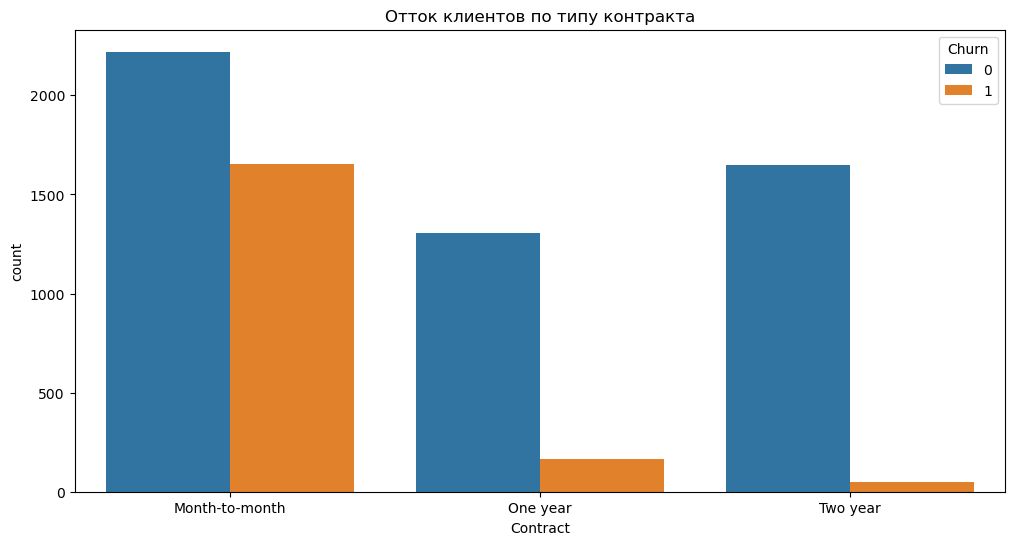

In [58]:
# Визуализации
plt.figure(figsize=(12, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Отток клиентов по типу контракта')
plt.show()

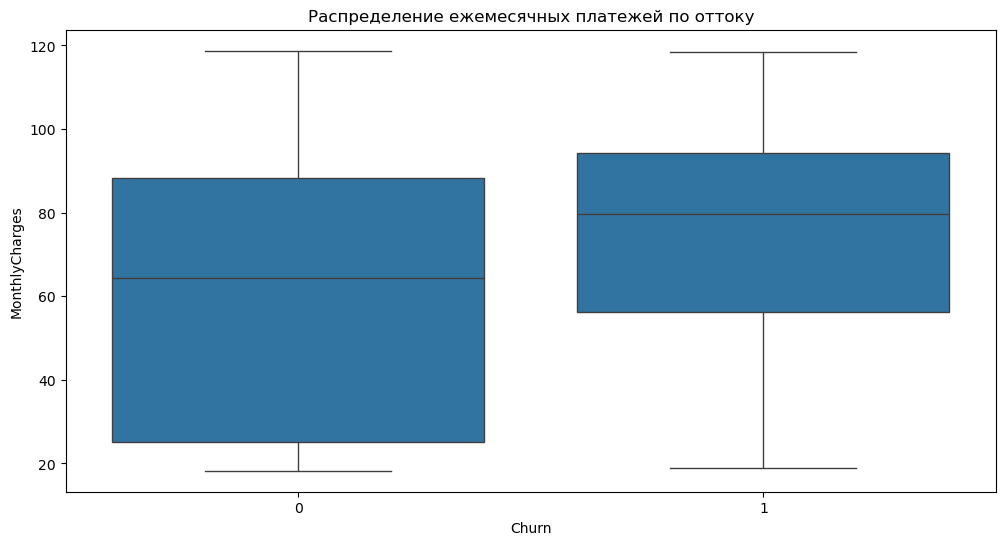

In [59]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Распределение ежемесячных платежей по оттоку')
plt.show()

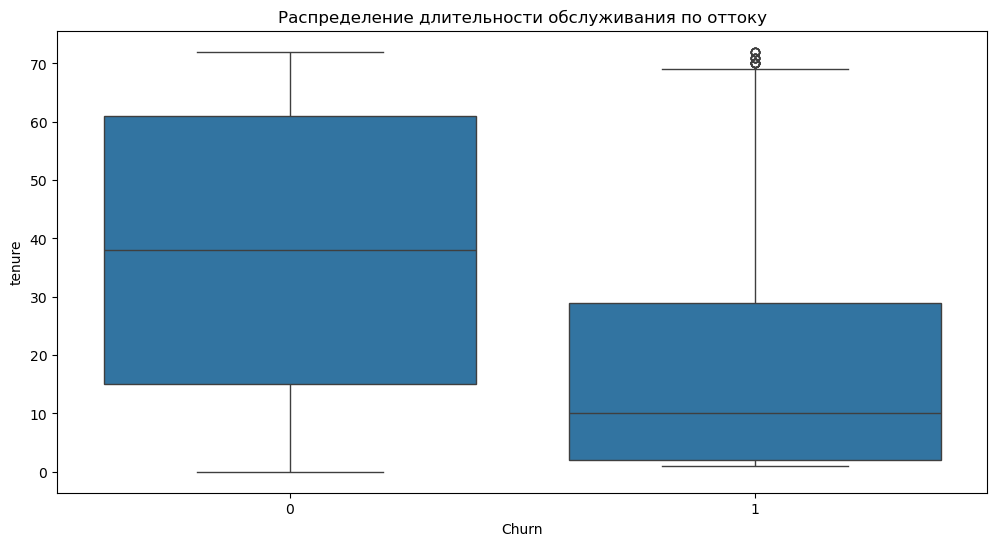

In [60]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Распределение длительности обслуживания по оттоку')
plt.show()

In [61]:
# Создание пайплайна с предобработкой и SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
])

In [62]:
# Применяем пайплайн к данным
X_train_processed, y_train_processed = pipeline.fit_resample(X_train, y_train)
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)

In [63]:
# Получение имен признаков после OneHotEncoding
if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(
        [col for col in X_train.columns if col not in ['tenure', 'MonthlyCharges', 'TotalCharges']]
    )
    all_features = ['tenure', 'MonthlyCharges', 'TotalCharges'] + list(cat_features)
    X_train_processed = pd.DataFrame(X_train_processed, columns=all_features)
    X_test_processed = pd.DataFrame(X_test_processed, columns=all_features)
else:
        all_features = ['tenure', 'MonthlyCharges', 'TotalCharges']  # если нет категориальных признаков    

In [64]:
# Базовые модели
models = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=sum(y_train==0)/sum(y_train==1)),
        'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
        'CatBoost': CatBoostClassifier(random_state=42, silent=True, auto_class_weights='Balanced'),
    }


Результаты для модели Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1552
           1       0.59      0.57      0.58       561

    accuracy                           0.78      2113
   macro avg       0.72      0.71      0.71      2113
weighted avg       0.78      0.78      0.78      2113

Матрица ошибок:
[[1331  221]
 [ 244  317]]


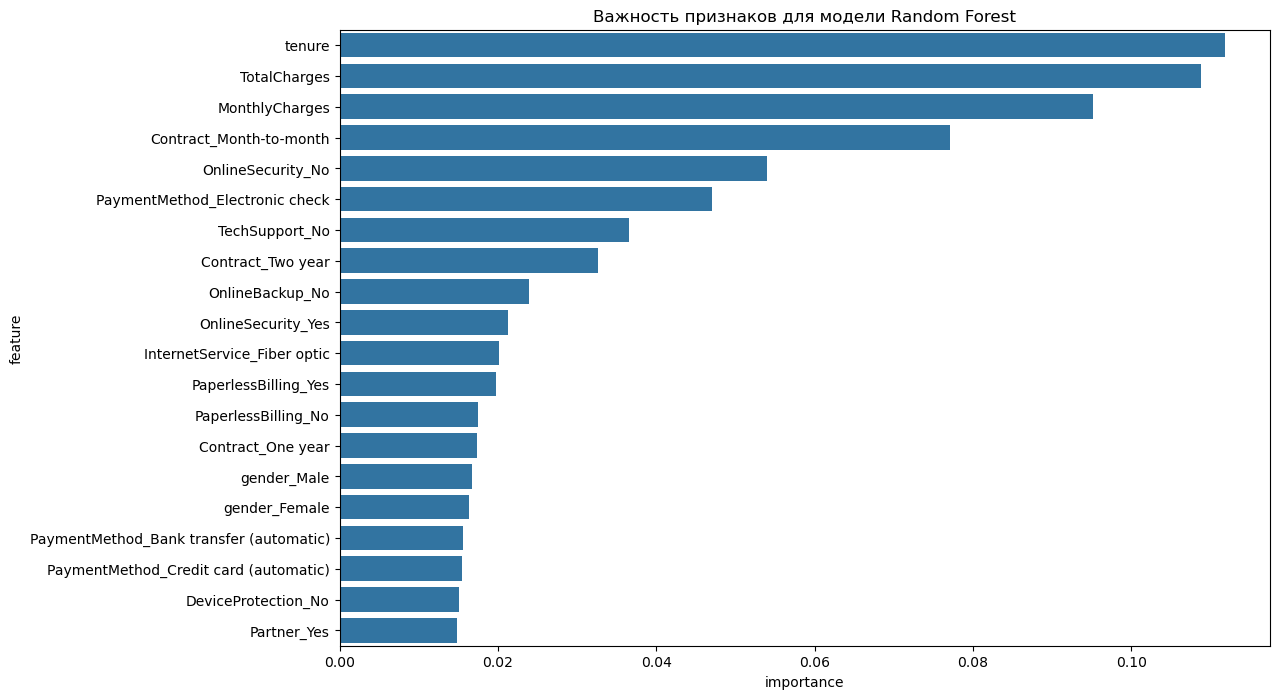


Результаты для модели XGBoost:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1552
           1       0.53      0.70      0.61       561

    accuracy                           0.76      2113
   macro avg       0.71      0.74      0.72      2113
weighted avg       0.79      0.76      0.77      2113

Матрица ошибок:
[[1210  342]
 [ 168  393]]


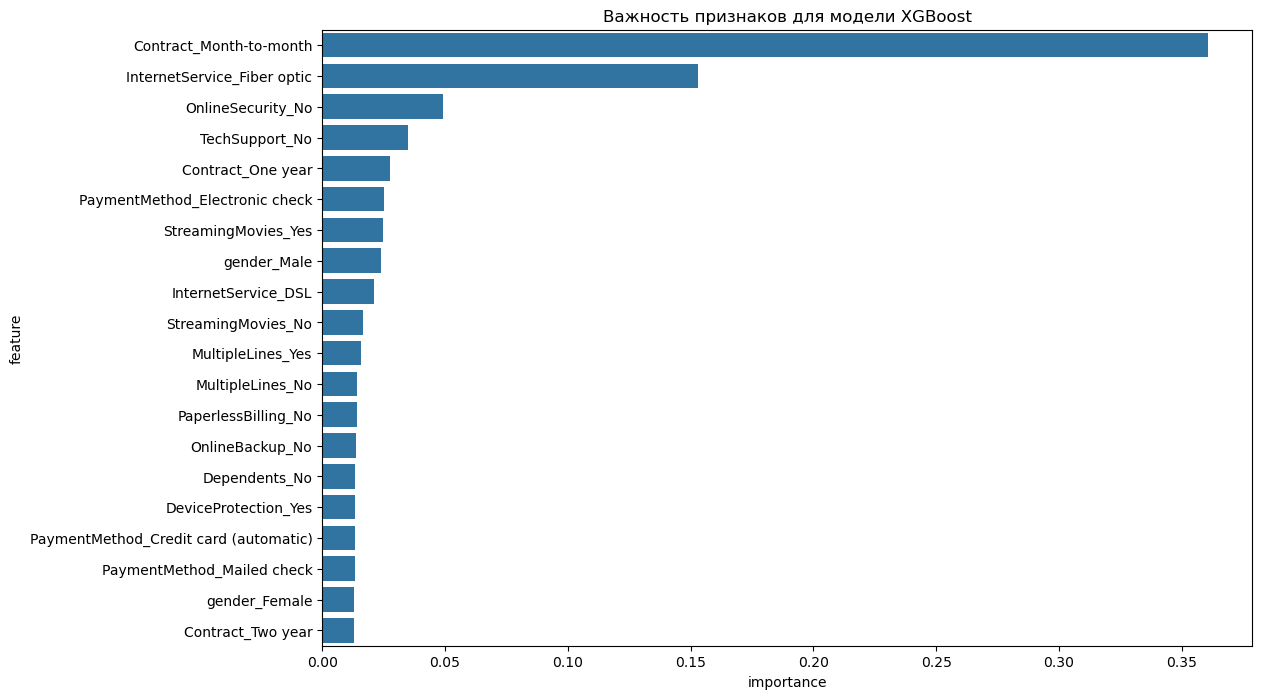

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3557
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Результаты для модели LightGBM:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1552
           1       0.59      0.59      0.59       561

    accuracy                           0.78      2113
   macro avg       0.72      0.72      0.72      2113
weighted avg       0.78      0.78      0.78      2113

Матрица ошибок:
[[1318  234]
 [ 230  331]]


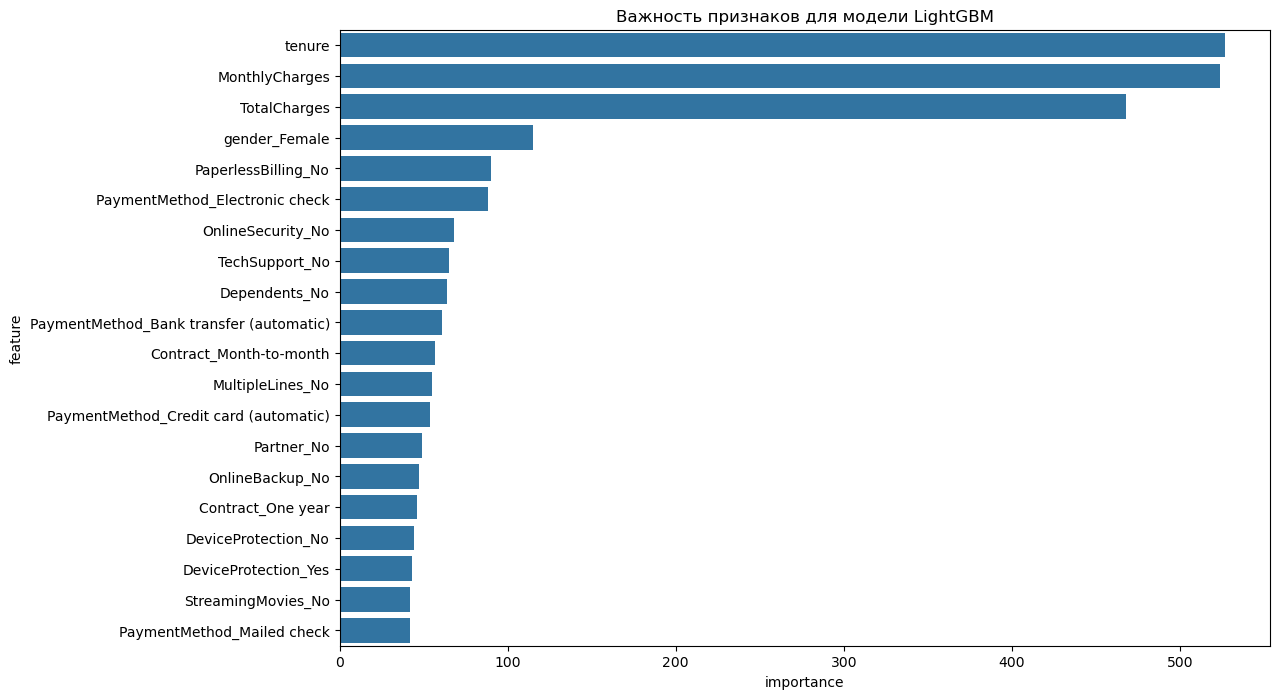


Результаты для модели CatBoost:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1552
           1       0.61      0.60      0.60       561

    accuracy                           0.79      2113
   macro avg       0.73      0.73      0.73      2113
weighted avg       0.79      0.79      0.79      2113

Матрица ошибок:
[[1336  216]
 [ 227  334]]


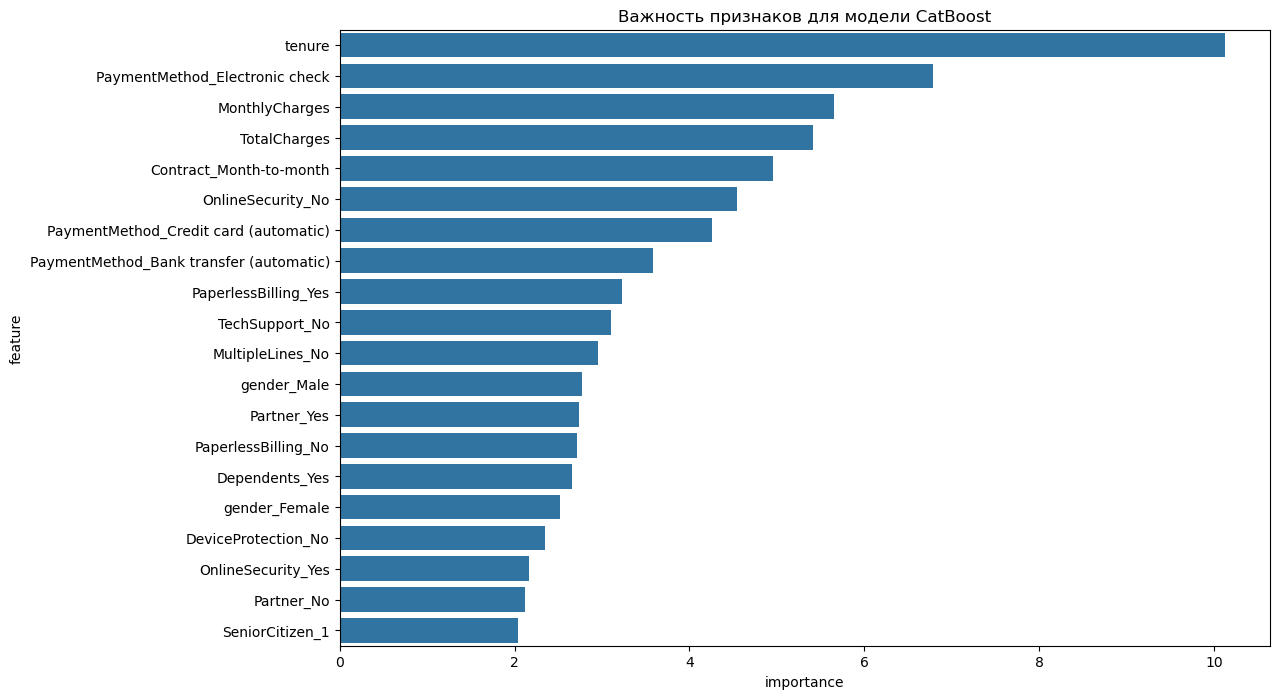

In [65]:
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_processed, X_test_processed, y_train_processed, y_test, name)
    results.append(result)
        
    # Визуализация важности признаков
    plot_feature_importance(model, all_features, name)

In [66]:
# Оптимизация моделей
print("\nНачинаем оптимизацию LightGBM...")
best_lgbm_params = optimize_lightgbm(X_train_processed, y_train_processed)
optimized_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)


Начинаем оптимизацию LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2414, number of negative: 2415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2409
[LightGBM] [Info] Number of data points in the train set: 4829, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [67]:
print("\nНачинаем оптимизацию XGBoost...")
best_xgb_params = optimize_xgb(X_train_processed, y_train_processed)
optimized_xgb = XGBClassifier(**best_xgb_params, random_state=42)


Начинаем оптимизацию XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие параметры: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
Лучший F1-score: 0.8566931362371641


In [68]:
# Оценка оптимизированных моделей
optimized_models = {
    'Optimized LightGBM': optimized_lgbm,
    'Optimized XGBoost': optimized_xgb,
    }
optimized_models

{'Optimized LightGBM': LGBMClassifier(colsample_bytree=0.9, max_depth=3, n_estimators=300,
                random_state=42, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9),
 'Optimized XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=0.2, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=None, num_parallel_tree=None, ...)}

In [69]:
result1 = evaluate_model(optimized_lgbm, X_train_processed, X_test_processed, y_train_processed, y_test, "Optimized LightGBM")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3557
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

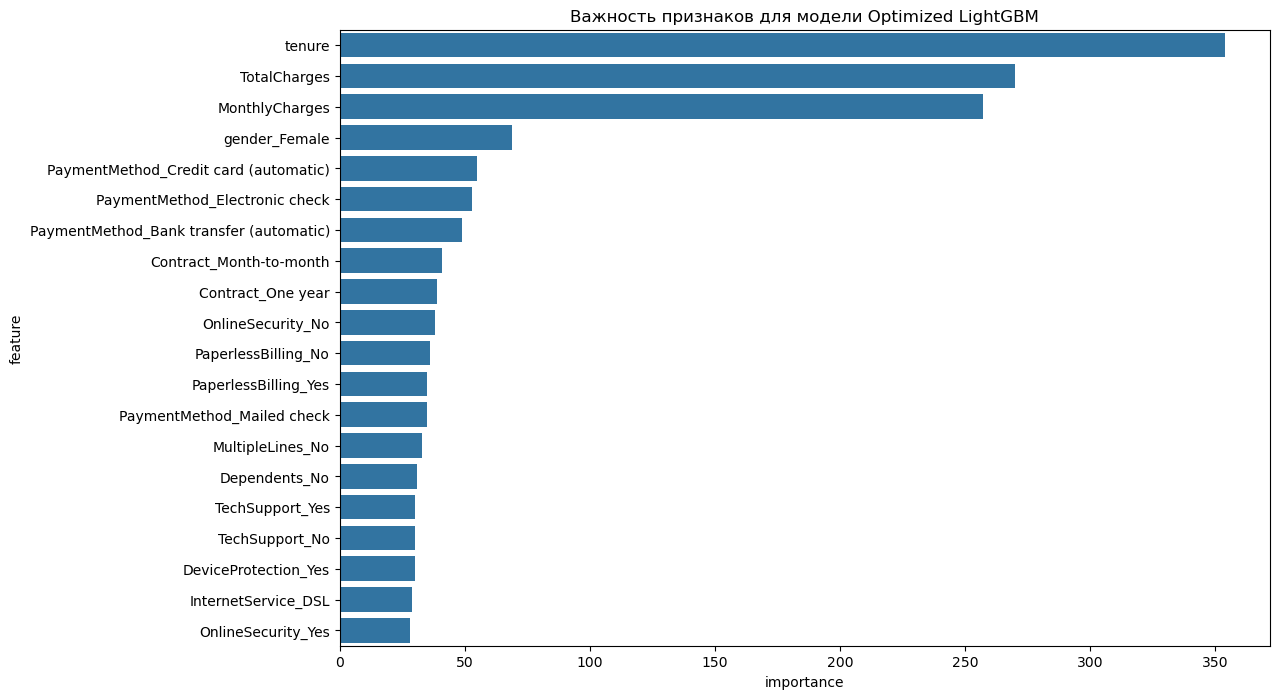

In [70]:
plot_feature_importance(optimized_lgbm, all_features, "Optimized LightGBM")

In [71]:
result2 = evaluate_model(optimized_xgb, X_train_processed, X_test_processed, y_train_processed, y_test, "Optimized XGBoost")


Результаты для модели Optimized XGBoost:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1552
           1       0.59      0.60      0.60       561

    accuracy                           0.78      2113
   macro avg       0.72      0.72      0.72      2113
weighted avg       0.79      0.78      0.78      2113

Матрица ошибок:
[[1323  229]
 [ 226  335]]


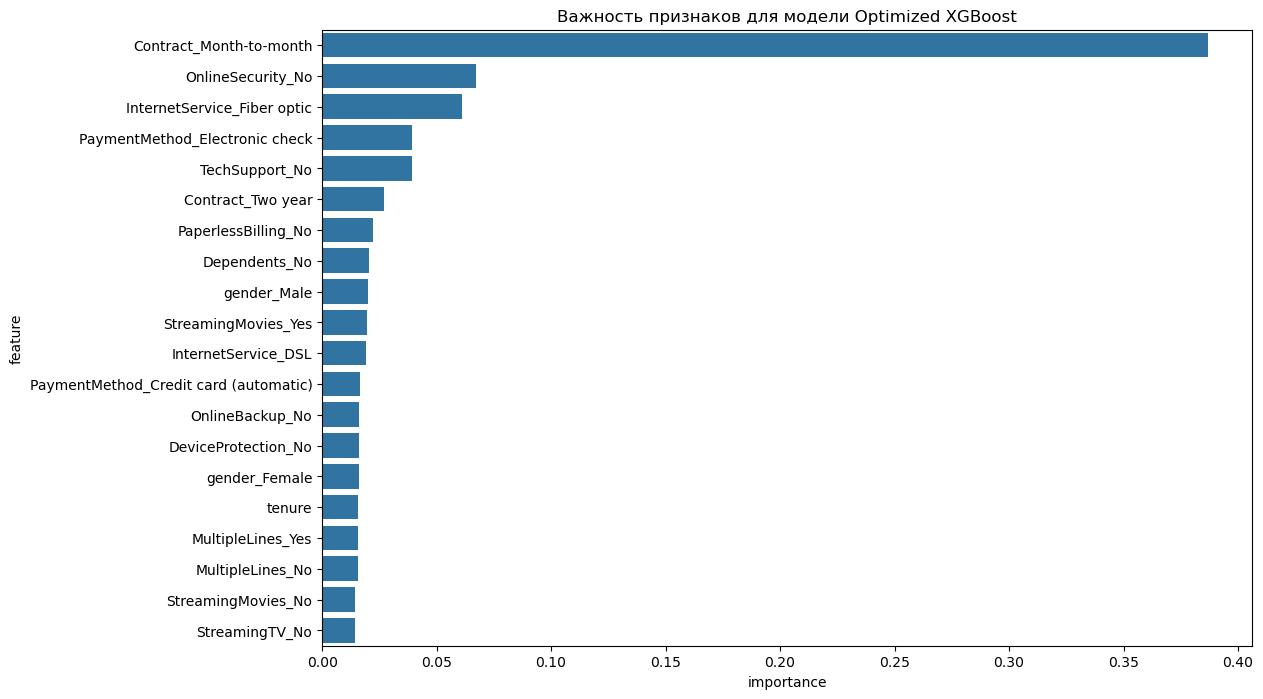

In [72]:
plot_feature_importance(optimized_xgb, all_features, "Optimized XGBoost")

In [73]:
# Создание ансамблевых моделей
# Voting Classifier
voting_clf = VotingClassifier(
        estimators=[
            ('lgbm', optimized_lgbm),
            ('xgb', optimized_xgb),
            ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ],
        voting='soft'
    )

In [74]:
# Stacking Classifier
stacking_clf = StackingClassifier(
        estimators=[
            ('lgbm', optimized_lgbm),
            ('xgb', optimized_xgb),
            ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ],
        final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
        cv=5
    )

In [75]:
# Оценка ансамблевых моделей
ensemble_models = {
        'Voting Ensemble': voting_clf,
        'Stacking Ensemble': stacking_clf
    }

In [76]:
results12 = evaluate_model(voting_clf, X_train_processed, X_test_processed, y_train_processed, y_test, 'Voting Ensemble')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3557
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [77]:
results22 = evaluate_model(stacking_clf, X_train_processed, X_test_processed, y_train_processed, y_test, 'Stacking Ensemble')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3557
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [78]:
# Сводная таблица результатов
results_df = pd.DataFrame(results)
print("\nСводная таблица результатов:")
print(results_df.sort_values('accuracy', ascending=False))


Сводная таблица результатов:
      model_name  accuracy        f1   roc_auc
3       CatBoost  0.790345  0.601260  0.728095
2       LightGBM  0.780407  0.587922  0.719622
0  Random Forest  0.779934  0.576888  0.711333
1        XGBoost  0.758637  0.606481  0.740087


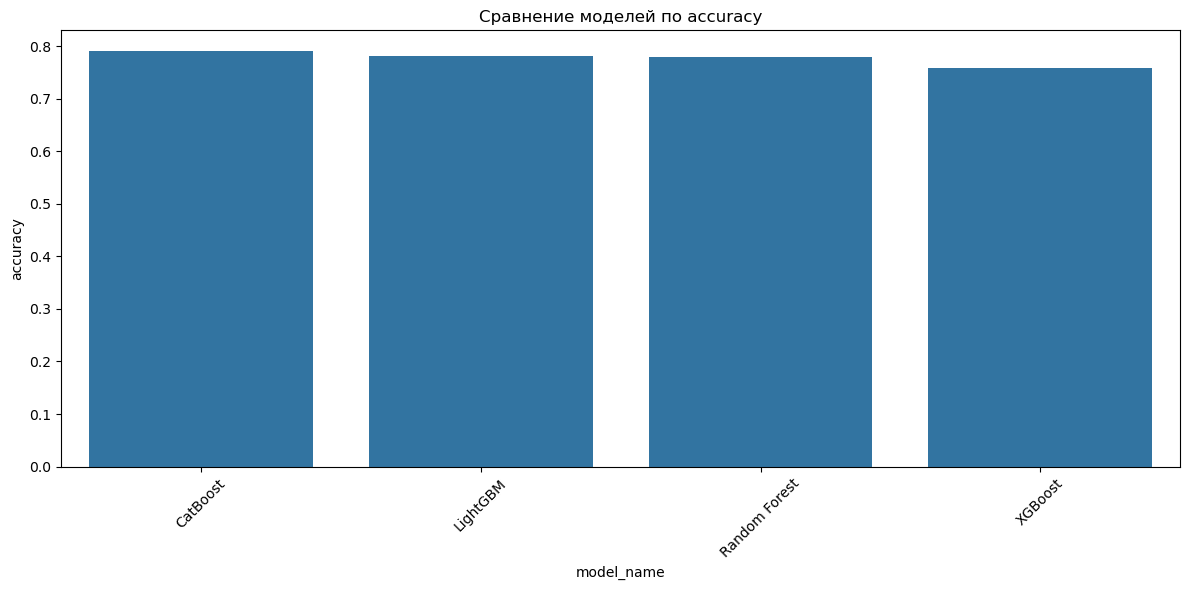

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2415, number of negative: 2415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2422
[LightGBM] [Info] Number of data points in the train set: 4830, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [79]:
# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))
sns.barplot(x='model_name', y='accuracy', data=results_df.sort_values('accuracy', ascending=False))
plt.title('Сравнение моделей по accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()